In [1]:
import logging
import string
import os
import pickle
from pprint import pprint
import re 
import numpy as np
import pandas as pd
from IPython.display import clear_output
from more_itertools import chunked

# NLTK
import nltk
from nltk.corpus import stopwords

# Gensim
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim

# SpaCy 
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline

# Logging if you want it
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# Suppressing it should you want to
logging.getLogger().setLevel(logging.CRITICAL)

# Suppressing warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

#SKLearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text

In [23]:
path=os.listdir(r"C:\Users\Li\Desktop\美国（txt）\split")
datalist=[]

for i in path:
    domain= r"C:\\Users\\Li\\Desktop\\美国（txt）\\split\\"+i
    #print(domain)
    with open(domain,"r",encoding="utf-8") as f:
        data=f.read()
        datalist.append(data)
len(datalist)

255

In [54]:
data2 = [re.sub(r'[^a-zA-Z\.:/]',' ',txt) for txt in datalist]
               
data1 = [txt.replace('\n', ' ') for txt in data2]

no_url = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', txt) for txt in data1]

no_line= [txt.replace('/', ' ').replace(':','').replace('PR NEWS','') for txt in no_url]

data = [re.sub(r'\s+', ' ', txt) for txt in no_line]

data[9]

' Hunan Pilot Free Trade Zone Creates New Heights of Inland Openness September CHANGSHA China Sept. ewswire Recently China Hunan Pilot Free Trade Zone has been officially approved. So far Free Trade Zones have been established in China. The movement that Hunan joins into the framework of Free Trade Zone will contribute for the coordinated development in Central China. Relying on their advantageous locations cities as Yueyang Changsha and Chenzhou have grown up to be the corridor for international cooperation investment and trade according to the Department of Commerce of Hunan Province. It is aimed to build Hunan a world class manufacturing cluster and a pilot zone for China Africa economic and trade cooperation. Owing to the ancient Silk Road and the proposal of Belt and Road Initiative Hunan has come with a good foundation for economic trade cooperation with Africa as they share a high degree of industrial fit and strong market complementarity. Hunan has been leading the way in econo

In [55]:
def tokenizer(texts):
    for text in texts:
        yield(gensim.utils.simple_preprocess(text, deacc=True))

token_list=list(tokenizer(data))

In [56]:
# Build bigram and trigram models
# min_count = min amount of tokens/bigrams in corpus. Threshold = score-based; higher = fewer phrases.
bigram = gensim.models.Phrases(token_list, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[token_list], threshold=100)  

# `Phraser` must be built from an initial `Phrases` instance. 
# It then works faster while using much less memory. See https://radimrehurek.com/gensim/models/phrases.html
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

stop = set(stopwords.words('english')+['ewswire','SOURCE','html','/','com','org','cn'])


def remove_stopwords(texts):
    return [[word for word in doc if word not in stop] for doc in texts]
      
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for doc in texts:
        joined = nlp(" ".join(doc)) 
     
        texts_out.append([token.lemma_ for token in joined if token.pos_ in allowed_postags])
    return texts_out


In [57]:
tokens_no_stops = remove_stopwords(token_list)

print(tokens_no_stops[0][1])

jilin


In [58]:
# Form trigrams
trigrams = make_trigrams(tokens_no_stops)

# Do lemmatization 
lemmas = lemmatization(trigrams)

In [59]:
# Create Dictionary 
dictionary = corpora.Dictionary(lemmas)

# Create Corpus, i.e. Document-Term Matrix
corpus = [dictionary.doc2bow(text) for text in lemmas]

In [62]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=18, 
                                           random_state=100,
                                           # eval_every = 20, # this is evaluation, perplexity
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [63]:
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.097649 -0.120524       1        1  15.904446
4      0.081617 -0.104669       2        1  12.746648
10     0.028415  0.100616       3        1   9.334964
12     0.084363  0.008085       4        1   9.125506
0      0.079259 -0.013084       5        1   8.167957
1     -0.207734 -0.030386       6        1   7.217959
11     0.065919  0.116396       7        1   6.340986
9      0.035660  0.011883       8        1   4.834421
14     0.066362 -0.032214       9        1   4.725938
13    -0.261505 -0.069420      10        1   4.273032
17     0.026297  0.131525      11        1   4.130112
5      0.042330 -0.096243      12        1   2.479380
6     -0.048579  0.038954      13        1   2.417949
2      0.014729 -0.036518      14        1   2.014429
16    -0.027723  0.093859      15        1   1.772240
3     -0.022516 -0.005414      16        1   1.606096
15     0.016430 -0.075325      17        1   1.489158
8     -0.070974  0.082479      18        1   1.418781, topic_info=             Term        Freq       Total Category  logprob  loglift
136           bri  516.000000  516.000000  Default  30.0000  30.0000
15          china  951.000000  951.000000  Default  29.0000  29.0000
640       network  241.000000  241.000000  Default  28.0000  28.0000
333      business  455.000000  455.000000  Default  27.0000  27.0000
4793         ping   79.000000   79.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
222       company    3.860813  455.105381  Topic18  -5.1947  -0.5143
370   information    3.121174  117.706979  Topic18  -5.4074   0.6254
552          bank    3.178588  205.208459  Topic18  -5.3892   0.0878
279         power    2.935597   48.541738  Topic18  -5.4687   1.4499
528       fintech    2.871551   29.773921  Topic18  -5.4908   1.9166

[1213 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2601      6  0.770423     abu
317       1  0.023549  access
317       2  0.164840  access
317       3  0.023549  access
317       4  0.023549  access
...     ...       ...     ...
427       2  0.632620    zone
427       4  0.017573    zone
427       5  0.087864    zone
427      16  0.017573    zone
4609     18  0.657283    zoom

[3295 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 11, 13, 1, 2, 12, 10, 15, 14, 18, 6, 7, 3, 17, 4, 16, 9])

In [34]:
%%time
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # A measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, corpus=corpus, texts=lemmas, dictionary=dictionary, coherence='c_v') 
# The higher the better. A coherence score of .4 means probably not right number of topics; .6 is great. Anything more is suspiciously great.
coherence = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence)


Perplexity:  -7.517631324438411

Coherence Score:  0.31807488933055483
Wall time: 15.7 s


In [35]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    total_amount = limit / step
    current_amount = 0
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, 
                                chunksize=500, passes=10, alpha='auto', per_word_topics=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        # When using 'c_v' texts should be provided, corpus isn’t needed. 
        # When using ‘u_mass’ corpus should be provided, if texts is provided, it will be converted to corpus using the dictionary 
        coherence_values.append(coherencemodel.get_coherence())
        current_amount += 1
        print("Built " + str(current_amount) + " of " + str(total_amount) + " models")

    return model_list, coherence_values

In [36]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=lemmas, start=10, limit=100, step=10)

Built 1 of 10.0 models
Built 2 of 10.0 models
Built 3 of 10.0 models
Built 4 of 10.0 models
Built 5 of 10.0 models
Built 6 of 10.0 models
Built 7 of 10.0 models
Built 8 of 10.0 models
Built 9 of 10.0 models


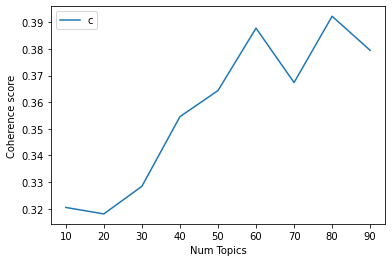

In [38]:
# Show graph
limit=100; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()